In [34]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn import svm
import xgboost as xgb

In [2]:
df_clients = pd.read_csv('mwc22-client_table.csv')
df_orders = pd.read_csv('mwc22-orders_table.csv')


# Analisis de ventas 



## Analisis Exploratorio

Primero hacemos una exploracion inicial sobre el dataset, en buscar de registros nulos o alguna otra anomalia

In [3]:
df_clients.head()

,CLIENT ID,CLIENT_SEGMENT,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
0,24321771,6,"67,25","201,75",0
1,24321859,2,"58,33",350,0
2,24321880,3,"46,67",112,0
3,24321957,2,50,600,0
4,24321962,4,10,120,0


In [4]:
df_clients.describe()

,CLIENT ID,CLIENT_SEGMENT,RECEIVED_COMMUNICATION
count,3.588400e+04,35884.000000,35884.000000
mean,2.706058e+07,3.123593,0.507998
std,8.835076e+06,1.512932,0.499943
min,1.807311e+07,1.000000,0.000000
25%,2.053311e+07,2.000000,0.000000
50%,2.462190e+07,3.000000,1.000000
75%,3.298538e+07,4.000000,1.000000
max,4.836594e+07,6.000000,1.000000


In [5]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35884 entries, 0 to 35883
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CLIENT ID               35884 non-null  int64 
 1   CLIENT_SEGMENT          35884 non-null  int64 
 2   AVG CONSO               35884 non-null  object
 3   AVG BASKET SIZE         35884 non-null  object
 4   RECEIVED_COMMUNICATION  35884 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.4+ MB


Observamos que las variables AVG CONSO y AVG BASKET SIZE no aparecen en la tabla de descripcion y la funcion .info() nos señala que son de tipo object y deberian ser de tipo float para poder realizar un analisis y poder manipularlas adecuadamente por lo tanto primero debemos canviar el tipo del atributo

In [6]:
for atr in df_clients.keys():
    if df_clients.dtypes[atr]==np.object:
        df_clients[atr].replace(',','.',inplace=True,regex=True)
        df_clients[atr]=df_clients[atr].astype(float)

In [7]:
df_clients.describe()

,CLIENT ID,CLIENT_SEGMENT,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
count,3.588400e+04,35884.000000,35884.000000,35884.000000,35884.000000
mean,2.706058e+07,3.123593,64.534437,181.218610,0.507998
std,8.835076e+06,1.512932,64.381932,129.604691,0.499943
min,1.807311e+07,1.000000,0.830000,10.000000,0.000000
25%,2.053311e+07,2.000000,20.830000,100.000000,0.000000
50%,2.462190e+07,3.000000,50.000000,160.000000,1.000000
75%,3.298538e+07,4.000000,88.170000,225.000000,1.000000
max,4.836594e+07,6.000000,2433.330000,3400.200000,1.000000


In [8]:
df_orders.head()

,CLIENT ID,NB PRODS,ORDER ID,FRUIT_PRODUCT
0,18070505,5,671907264,Apple
1,18070505,10,671907264,Orange
2,18070505,5,671907264,Kiwi
3,18070505,10,671907264,Pear
4,18070505,5,671907264,Cheery


In [9]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66912 entries, 0 to 66911
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CLIENT ID      66912 non-null  int64 
 1   NB PRODS       66912 non-null  int64 
 2   ORDER ID       66912 non-null  int64 
 3   FRUIT_PRODUCT  66912 non-null  object
dtypes: int64(3), object(1)
memory usage: 2.0+ MB


In [10]:
df_orders.describe()

,CLIENT ID,NB PRODS,ORDER ID
count,6.691200e+04,66912.000000,6.691200e+04
mean,2.613407e+07,4.528112,6.722533e+08
std,8.473596e+06,5.788227,3.205826e+06
min,1.807050e+07,-80.000000,6.638335e+08
25%,2.017427e+07,1.000000,6.694803e+08
50%,2.438055e+07,3.000000,6.719971e+08
75%,2.538708e+07,5.000000,6.750893e+08
max,4.836586e+07,198.000000,6.832132e+08


### *Analisis univariable*

**CLIENT_SEGMENT**

la variable CLIENT_SEGMENT es de tipo categorica que nos agrupa los clientes por segmento  del 1 al 6.

agrupamos todos los clientes en funcion del segmento al que corresponden para ver el tamaño que ocupan en cada segmento

In [11]:
clients_segment=df_clients['CLIENT_SEGMENT'].value_counts().reset_index().rename(columns={'index': 'clients_segment','CLIENT_SEGMENT':'total_clients'})
clients_segment['total_pct']= (clients_segment.total_clients/clients_segment.total_clients.sum())*100

In [12]:
cl_seg_plt =clients_segment.sort_values(by=['clients_segment']).reset_index(drop=True)

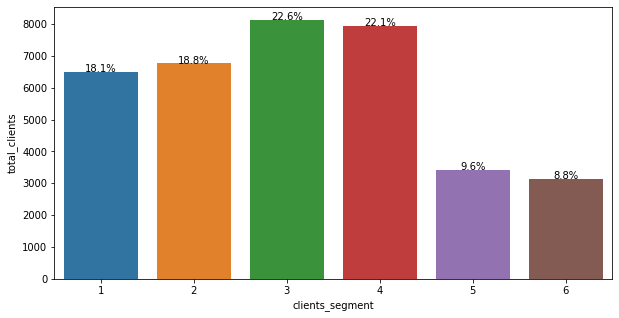

In [13]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x="clients_segment", y="total_clients", data=cl_seg_plt)
patches = ax.patches
for i in range(len(patches)):
    
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()+0.5
    ax.annotate('{:.1f}%'.format(cl_seg_plt['total_pct'][i]), (x, y), ha='center')

plt.show()

Observamos que en los segmentos 3 y 4 son los segmentos mas grandes con el 22% de clientes seguido del los de los segmentos 1 y 2 con el 18% de clientes y finalmente los segmentos 5 y 6 con el 9% y 8% restante de clientes

**AVG CONSO**

La variable AVG CONSO es una  variable de tipo continua del conumo promedio mensual por cliente.

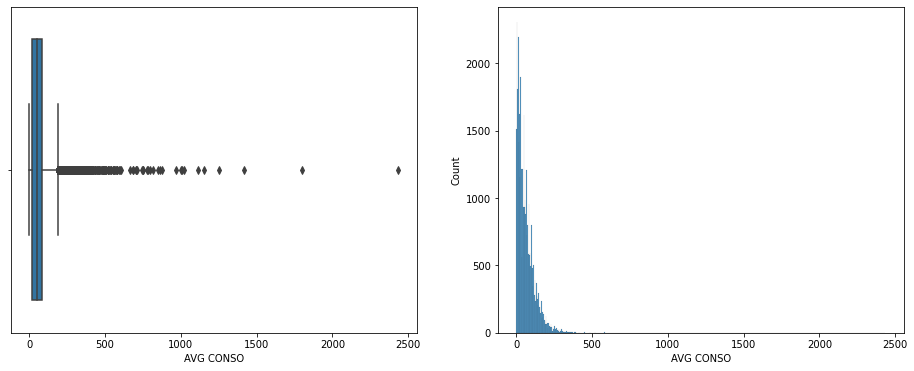

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(data=df_clients,ax=axes[0], x="AVG CONSO")
sns.histplot(data=df_clients,ax=axes[1], x="AVG CONSO")
plt.show()

en los graficos nos muestra la aparicion de outliers dado que el grueso de medias de consumo  estan muy por debajo de los  maximos

**AVG BASKET SIZE**

es una variable de tipo continua  que contiene el tamaño medio mensual de la cesta por cliente

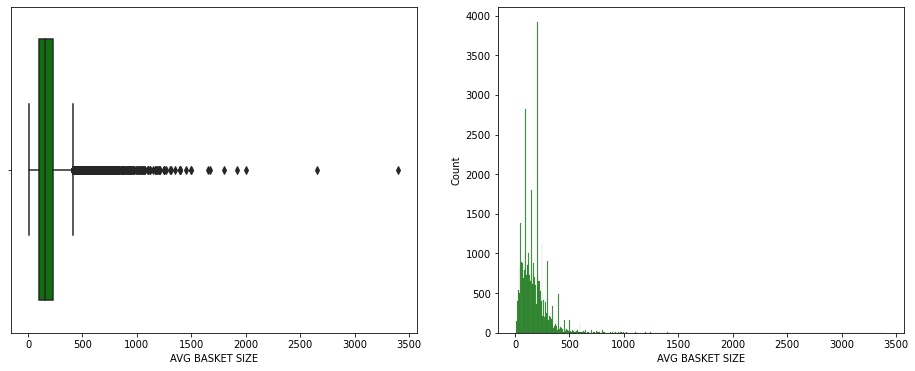

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(data=df_clients,ax=axes[0], x="AVG BASKET SIZE",color='g')
sns.histplot(data=df_clients,ax=axes[1], x="AVG BASKET SIZE",color='g')
plt.show()

**RECEIVED_COMMUNICATION**

Es una variable booleana de tipo categorica donde indica si un cliente ha recibido promocion de los productos que compró

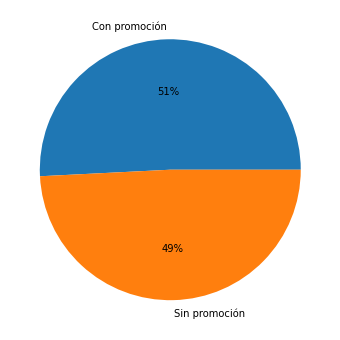

In [16]:
plt.figure(figsize=(10,6))
colors = sns.color_palette('tab10')
labels=['Con promoción','Sin promoción']
plt.pie(df_clients['RECEIVED_COMMUNICATION'].value_counts(),labels=labels, colors = colors, autopct='%.0f%%')
plt.show()

El anterior grafico nos muestra que el 51% de los clientes recibieron promocion de los productos que compraron respecto al 49% que no recibieron promocion de los productos

## *Analisis Multivariable*

Seguidamente analizamos que caracteristicas en particular tiene cada segmento

*consumo y tamaño de la cesta  por segmentos*

In [17]:
grouped = df_clients.groupby('CLIENT_SEGMENT')[['AVG CONSO','AVG BASKET SIZE']].apply(sum)

In [18]:
grouped = grouped.reset_index().rename(columns={'index': 'clients_segment','AVG CONSO':'total avg conso',
                                                'AVG BASKET SIZE':'total avg basket size'})

In [19]:
grouped

,CLIENT_SEGMENT,total avg conso,total avg basket size
0,1,860472.89,1238138.77
1,2,590555.30,2018506.81
2,3,351980.56,1328939.97
3,4,165420.78,836102.49
4,5,22632.66,195016.85
5,6,324691.54,886143.70


<AxesSubplot:xlabel='CLIENT_SEGMENT', ylabel='AVG BASKET SIZE'>

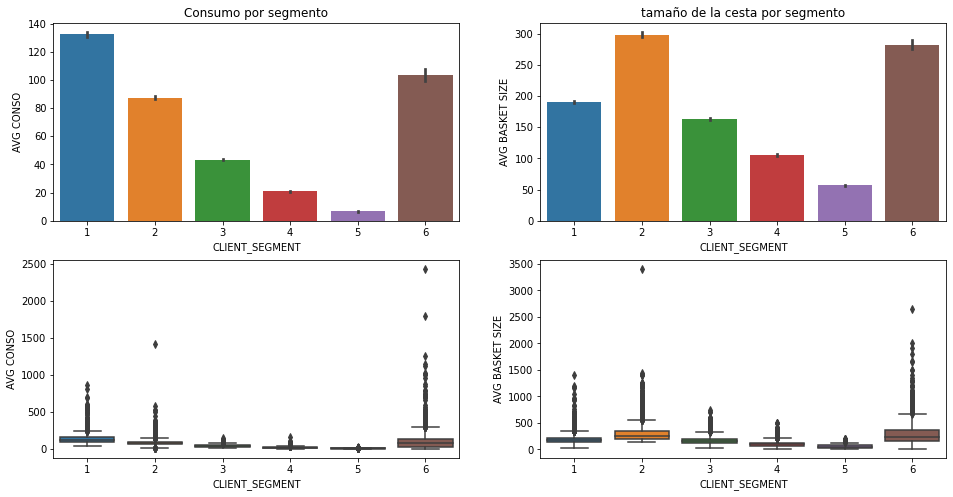

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
sns.barplot(x="CLIENT_SEGMENT", y="AVG CONSO", data=df_clients,ax=axes[0][0]).set(title="Consumo por segmento")
sns.barplot(x="CLIENT_SEGMENT", y="AVG BASKET SIZE", data=df_clients,ax=axes[0][1]).set(title="tamaño de la cesta por segmento")
sns.boxplot(x="CLIENT_SEGMENT", y="AVG CONSO", data=df_clients,ax=axes[1][0])
sns.boxplot(x="CLIENT_SEGMENT", y="AVG BASKET SIZE", data=df_clients,ax=axes[1][1])

observamos que el consumo por segmentos  decrece exceptuando el segmento 6, que se colocaria entre el segmento 1 y 2.Por lo tanto, el orden de mayor a menor respecto el consumo mensual seria 1,6,2,3,4,5

al realizar un boxplot observamos la presencia de bastantes outliers sobretodo en el segmento 6, para tener un analisis mas representativo del conjunto debemos tratarlos

*Tratamiento de outliers sobre avg conso y avg basket size*

In [21]:
def outlier_treatment(datacolumn):
    #sorted(datacolumn)
    q1,q3= np.percentile(datacolumn , [25,75])
    iqr = q3 - q1
    lower_range = q1 - (1.5 * iqr)
    upper_range = q3 + (1.5 * iqr)
    return lower_range,upper_range

In [22]:
for x in ['AVG CONSO','AVG BASKET SIZE']:
    lowerbound,upperbound = outlier_treatment(df_clients[x])
    print(x)
    print("lower",lowerbound)
    print("upper",upperbound)
    df_clients.drop(df_clients[ (df_clients[x] > upperbound) | (df_clients[x]< lowerbound) ].index,inplace=True )

AVG CONSO
lower -80.18
upper 189.18
AVG BASKET SIZE
lower -75.005
upper 391.67499999999995


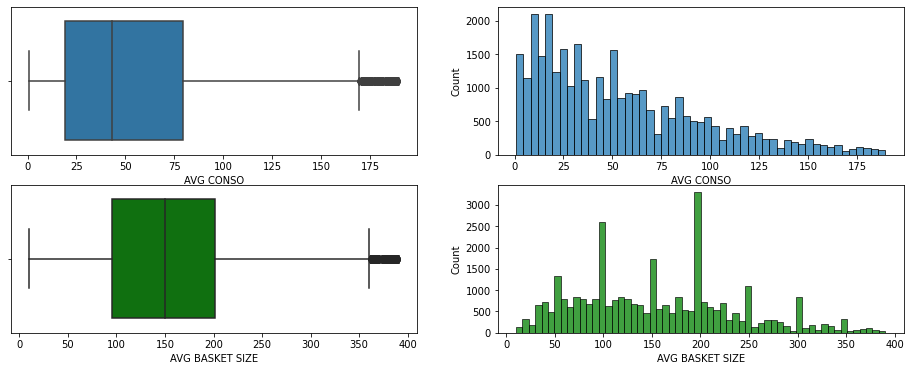

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(16, 6))
sns.boxplot(data=df_clients,ax=axes[0][0], x="AVG CONSO")
sns.histplot(data=df_clients,ax=axes[0][1], x="AVG CONSO")
sns.boxplot(data=df_clients,ax=axes[1][0], x="AVG BASKET SIZE",color='g')
sns.histplot(data=df_clients,ax=axes[1][1], x="AVG BASKET SIZE",color='g')
plt.show()

<AxesSubplot:xlabel='CLIENT_SEGMENT', ylabel='AVG BASKET SIZE'>

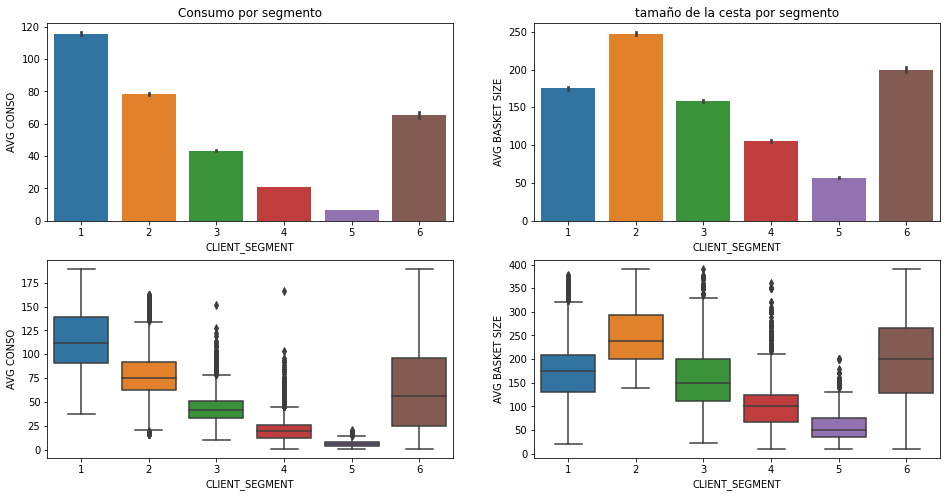

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
sns.barplot(x="CLIENT_SEGMENT", y="AVG CONSO", data=df_clients,ax=axes[0][0]).set(title="Consumo por segmento")
sns.barplot(x="CLIENT_SEGMENT", y="AVG BASKET SIZE", data=df_clients,ax=axes[0][1]).set(title="tamaño de la cesta por segmento")
sns.boxplot(x="CLIENT_SEGMENT", y="AVG CONSO", data=df_clients,ax=axes[1][0])
sns.boxplot(x="CLIENT_SEGMENT", y="AVG BASKET SIZE", data=df_clients,ax=axes[1][1])

una vez tratados los outliers en las variables avg conso y avg basket size  ya podemos observar una clasificacion en los segmentos de clientes

Observamos que los clientes del segmento 1 son el grupo con la media de consumo anual mas alta aunque no es el grupo con  el tamaño medio de la cesta mas grande , podemos deducir que  no por tener un consumo mas alto significa un tamaño de cesta mayor

In [25]:
seg_conso_basket = df_clients.groupby('CLIENT_SEGMENT')[['AVG CONSO','AVG BASKET SIZE']].mean()

In [26]:
seg_conso_basket

,AVG CONSO,AVG BASKET SIZE
CLIENT_SEGMENT,,
1,115.648036,174.889339
2,78.644968,247.624787
3,43.403543,158.852061
4,20.844386,104.953562
5,6.600367,56.872805
6,65.657012,199.918614


*Relacion entre promocion y consumo*

Text(0.5, 0.98, 'Impacto de la promocion respecto consumo')

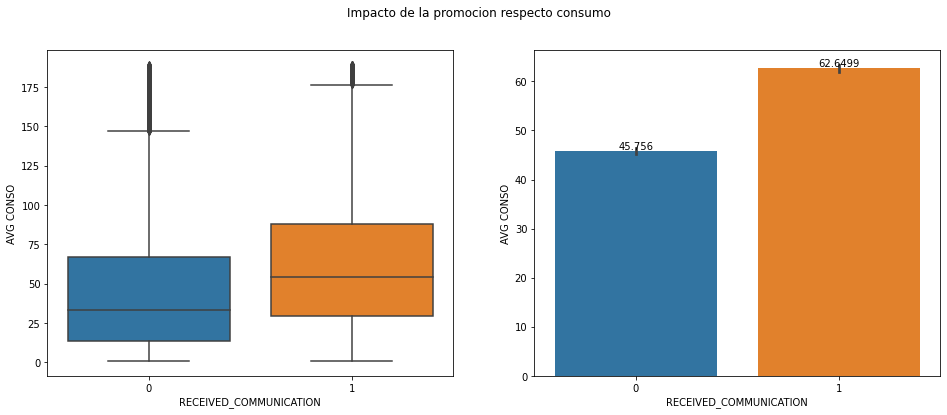

In [27]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(x="RECEIVED_COMMUNICATION", y="AVG CONSO",ax=axes[0], data=df_clients)
ax=sns.barplot(x="RECEIVED_COMMUNICATION", y="AVG CONSO",ax=axes[1], data=df_clients)
ax.bar_label(ax.containers[0])
fig.suptitle('Impacto de la promocion respecto consumo')

In [28]:
communication_cons = df_clients.groupby('RECEIVED_COMMUNICATION')[['AVG CONSO']].mean()

In [29]:
round(communication_cons.loc[1,'AVG CONSO']-communication_cons.loc[0,'AVG CONSO'],2)

16.89

El grafico nos muestra que los clientes que si recibieron promocion de los productos compran de  media un 16,89% mas que los que no recibieron promocion

*Relacion entre promocion y tamaño de la cesta*

Text(0.5, 0.98, 'Impacto de la promocion respecto al tamaño de la cesta')

<Figure size 720x432 with 0 Axes>

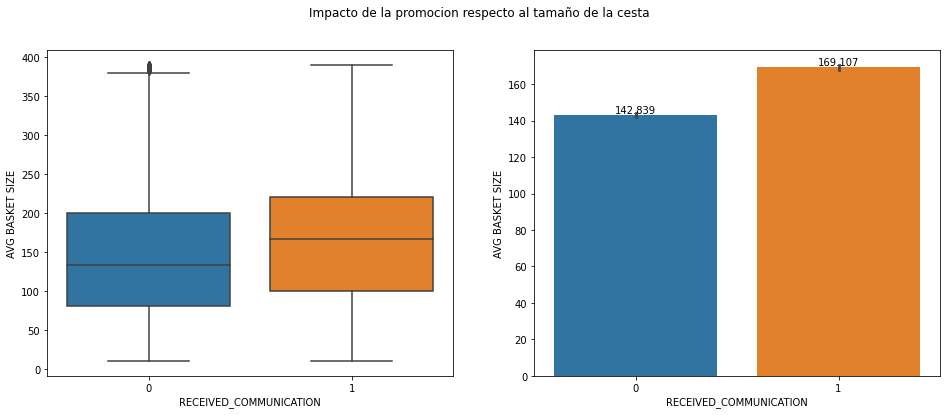

In [30]:
plt.figure(figsize=(10,6))
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(x="RECEIVED_COMMUNICATION", y="AVG BASKET SIZE",ax=axes[0], data=df_clients)
ax =sns.barplot(x="RECEIVED_COMMUNICATION", y="AVG BASKET SIZE",ax=axes[1], data=df_clients)
ax.bar_label(ax.containers[0])
fig.suptitle('Impacto de la promocion respecto al tamaño de la cesta')

Obsevamos que los clientes que recibieron promocion aumentan el tamaño de la cesta  un 26% mas respecto a los que no recibieron promocion

# Actividad del cliente

### Analisis univariable

**NB PRODS**

variable  categorica  que contiene el numero de productos de la variedad de fruta con escala 1 : 10

<AxesSubplot:xlabel='NB PRODS'>

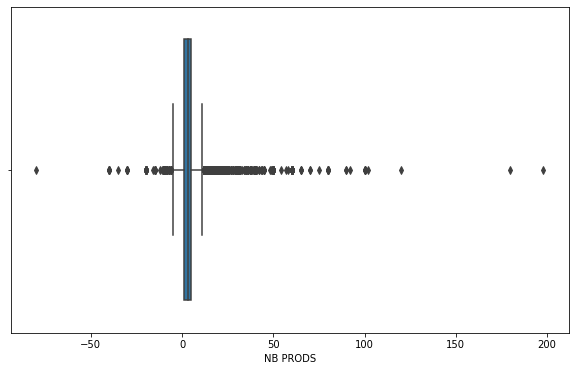

In [181]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_orders, x="NB PRODS")

In [182]:
df_orders['NB PRODS'].unique()

array([  5,  10,  15,   3,   9,   2,   4,   6,   1,   7,   8,  20,  30,
        18,  40, -40,  11,  12,  14,  -5,  16,  60,  21,  70,  13,  19,
        27,  24,  25,  22,  -2,  35,  17,  50, -20,  43,  -6,  26,  38,
        36,  39,  28,  80,  44, -10,  -3,  -1,  29,  32,  23,  -7,  -4,
        -8,  75,  31, 100, -30, 198, -15,  54,  90,  45,  34,  65,  58,
        48,  41, 120, 180, -12, -11,  42,  -9, -16,  37,  57,  33,  92,
        49, 102, -35, -80], dtype=int64)

observamos que hay registros negativos, puede ser debido que  el cliente en un primer lugar ordena el producto pero antes de cerrar el pedido lo descarta


In [183]:
df_orders.loc[df_orders['NB PRODS']<0]['CLIENT ID'].unique()

array([18090840, 18115855, 18362804, 18489723, 18633239, 18698768,
       18803169, 18809103, 18851598, 19016477, 19147056, 19246696,
       19275179, 19651613, 19850202, 19950240, 19981232, 20037550,
       20042062, 20176306, 20231861, 20377967, 20504796, 20563810,
       20697009, 20711202, 20763401, 20822443, 21178064, 21178780,
       21258985, 21264556, 21455607, 21516224, 21522244, 21609080,
       21624343, 21632340, 21676182, 21742337, 21811811, 21829443,
       21882527, 21912288, 22006237, 37545185, 38487166, 38776055,
       39245523, 39293252, 41685906, 42728929, 44756626, 47059235,
       24338355, 24347950, 24398246, 24428428, 24517007, 24543175,
       24624295, 24649727, 24650831, 24655914, 24681049, 24695092,
       24781043, 24790894, 24810086, 24812423, 24815973, 24846479,
       24850950, 24856734, 24862305, 24877844, 24913990, 24949437,
       24961707, 24985516, 24993342, 25104970, 25283744, 25342966,
       25381673, 25394668, 25464005, 32979574, 33615519, 35721

In [184]:
df_orders.loc[df_orders['CLIENT ID']==18115855]

,CLIENT ID,NB PRODS,ORDER ID,FRUIT_PRODUCT
398,18115855,5,676134225,Lime
399,18115855,3,667504655,Lime
400,18115855,5,675226512,Lime
401,18115855,-5,675226512,Lime
402,18115855,3,671906578,Lime
403,18115855,2,671906578,Jackfruit
404,18115855,1,667504655,Jackfruit
405,18115855,1,667504655,Lemon
406,18115855,1,673138895,Nectarine
407,18115855,1,673138895,Pear


In [185]:
df_orders.loc[df_orders['CLIENT ID']==48341696]

,CLIENT ID,NB PRODS,ORDER ID,FRUIT_PRODUCT
66897,48341696,20,669547626,Nuwe Fruit
66898,48341696,-20,668265264,Nuwe Fruit
66899,48341696,20,668265264,Nuwe Fruit


Efectivamente, vemos que el cliente  en el mismo pedido hace y deshace encargos, podria ser debido a un error al añadir el producto a la cesta

Vamos a comprobar el numero de veces que ocurre este suceso

In [186]:
miss_click=df_orders.loc[df_orders['NB PRODS']<0]['ORDER ID'].count()

In [187]:
total = df_orders['NB PRODS'].count()

In [188]:
print("Porcentage de error en la orden:\n {}%".format(round((miss_click/total)*100,2)))

Porcentage de error en la orden:
 0.54%


In [189]:
negative_orders=df_orders.copy()
negative_orders=df_orders.copy()
negative_orders=df_orders.groupby(['CLIENT ID','ORDER ID','FRUIT_PRODUCT'])['NB PRODS'].sum()
negative_orders=negative_orders.reset_index()
negative_orders['NB PRODS'].unique()

array([  5,  10,  15,   3,   9,   6,   2,   4,   1,   7,   8,  30,  20,
        18,   0,  40,  13,  12,  14,  16,  28,  60,  21,  72,  11,  19,
        27,  24,  22,  25,  35,  17,  50, -20,  43,  26,  38,  36,  39,
        80,  44,  -1,  -3,  -5,  29,  32,  23,  -7,  -4,  -8, -10,  -2,
        31,  70, 100,  55, 198, -15,  54,  90,  45,  34,  65,  58,  48,
       110,  41, 120, 180,  42, -30, -16,  -9, -40,  37,  64,  -6,  57,
        33,  92,  49, 102, -35, -80], dtype=int64)

presuponiendo que es un error durante el pedido, hemos restado por pedido y cliente el producto que en un principio puso en la cesta pero luego lo elimino total o parcialmente

In [190]:
negative_orders.loc[negative_orders['NB PRODS']<0]['CLIENT ID'].unique()

array([18489723, 18851598, 19147056, 19246696, 19275179, 19850202,
       20563810, 20711202, 21742337, 21811811, 21912288, 24624295,
       24681049, 24695092, 24790894, 24815973, 24850950, 24877844,
       24985516, 25104970, 25283744, 25394668, 33615519, 35721925,
       38487166, 42742047, 44756626, 45779975, 46885586], dtype=int64)

In [191]:
negative_orders.loc[negative_orders['ORDER ID']==665673010]

,CLIENT ID,ORDER ID,FRUIT_PRODUCT,NB PRODS
3030,18489723,665673010,Coconut,-20


aun asi nos encontramos que hay pedidos con un balance negativo o que tienen un solo registro con el numero de productos negativo, como no pueden haber pedidos negativos los descartaremos

In [313]:
df_trim_orders= negative_orders.drop(negative_orders[negative_orders['NB PRODS']<0].index)
df_trim_orders

,CLIENT ID,ORDER ID,FRUIT_PRODUCT,NB PRODS
0,18070505,671907264,Apple,5
1,18070505,671907264,Cheery,5
2,18070505,671907264,Kiwi,5
3,18070505,671907264,Orange,10
4,18070505,671907264,Pear,10
...,...,...,...,...
65042,48352045,670065547,Watermelon,2
65043,48365750,670187349,Lemon,9
65044,48365750,670187349,Papaya,1
65045,48365861,668693229,Lemon,5


<AxesSubplot:xlabel='NB PRODS'>

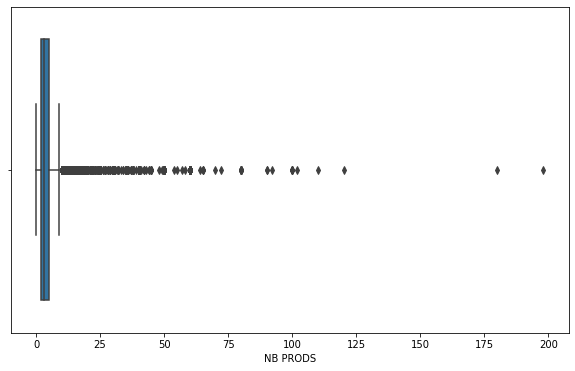

In [195]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_trim_orders, x="NB PRODS")

Observamos presencia de outliers que distorsionan la tendencia del conjunto


**FRUIT_PRODUCT**

Es una variable categorica que contiene el tipo de fruta que el cliente ha comprado

In [196]:
common_fruits=df_trim_orders['FRUIT_PRODUCT'].value_counts().reset_index().rename(columns={'index':'fruit_type','FRUIT_PRODUCT':'count'})
common_fruits['total_pct']=round((common_fruits['count']/common_fruits['count'].sum())*100,2)

In [197]:
common_fruits

,fruit_type,count,total_pct
0,Kiwi,6038,9.30
1,Orange,5469,8.42
2,Lemon,5116,7.88
3,Cheery,4046,6.23
4,Nuwe Fruit,3660,5.64
5,Pear,3659,5.63
6,Nectarine,3492,5.38
7,Banana,3385,5.21
8,Apple,3382,5.21
9,Grape,3090,4.76


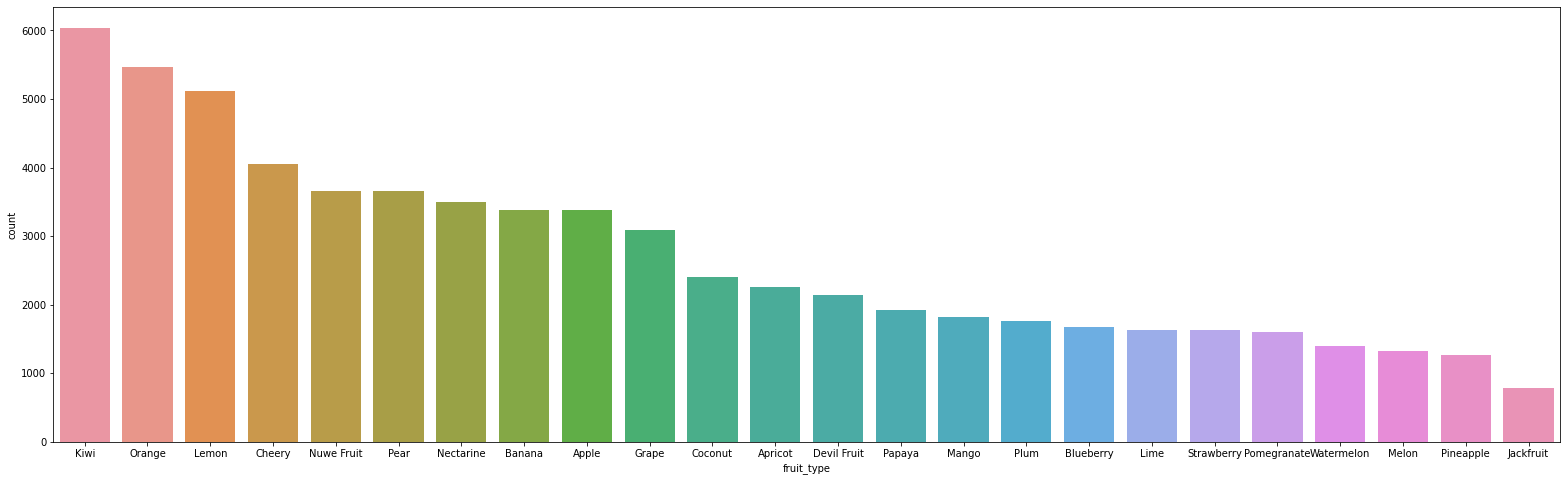

In [198]:
plt.figure(figsize=(27,8))
ax = sns.barplot(x="fruit_type", y="count", data=common_fruits)

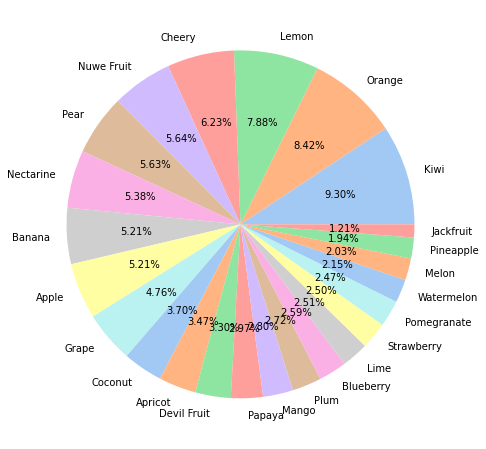

In [199]:
plt.figure(figsize=(12,8))
colors = sns.color_palette('pastel')
plt.pie(common_fruits['count'], labels = common_fruits['fruit_type'], colors = colors, autopct='%.02f%%')
plt.show()

Obsevamos que el nombre del producto que mas aparece en los registros es el kiwi que representa el 9% de las entradas y el que menos jackfruit con un 1%

### Analisis multivariable

In [314]:
fruit_group = df_trim_orders.groupby(['CLIENT ID'])['NB PRODS'].sum()
fruit_group= fruit_group.reset_index()
order_group = df_trim_orders.groupby('CLIENT ID')['ORDER ID'].count().rename('total orders')

order_group=order_group.reset_index()

order_group=pd.merge(order_group,fruit_group,on="CLIENT ID")

In [315]:
order_group=order_group.rename(columns={'NB PRODS':'total_product'})

In [316]:
df_trim_orders

,CLIENT ID,ORDER ID,FRUIT_PRODUCT,NB PRODS
0,18070505,671907264,Apple,5
1,18070505,671907264,Cheery,5
2,18070505,671907264,Kiwi,5
3,18070505,671907264,Orange,10
4,18070505,671907264,Pear,10
...,...,...,...,...
65042,48352045,670065547,Watermelon,2
65043,48365750,670187349,Lemon,9
65044,48365750,670187349,Papaya,1
65045,48365861,668693229,Lemon,5


In [317]:
for x in ['total_product','total orders']:
    lowerbound,upperbound = outlier_treatment(order_group[x])

   
    print("upper",x,upperbound)
    order_group.drop(order_group[ (order_group[x] > upperbound) ].index,inplace=True )

    df_trim_orders= pd.merge(df_trim_orders,order_group,how='inner',on='CLIENT ID')

   


upper total_product 47.5
upper total orders 12.0


In [318]:
df_trim_orders.drop(['total orders_y','total_product_y'],axis=1,inplace=True)

In [319]:
df_trim_orders

,CLIENT ID,ORDER ID,FRUIT_PRODUCT,NB PRODS,total orders_x,total_product_x
0,18070505,671907264,Apple,5,5,35
1,18070505,671907264,Cheery,5,5,35
2,18070505,671907264,Kiwi,5,5,35
3,18070505,671907264,Orange,10,5,35
4,18070505,671907264,Pear,10,5,35
...,...,...,...,...,...,...
55034,48352045,670065547,Watermelon,2,8,10
55035,48365750,670187349,Lemon,9,2,10
55036,48365750,670187349,Papaya,1,2,10
55037,48365861,668693229,Lemon,5,2,15


*Cliente medio*

In [320]:
avg_client=df_trim_orders.groupby(['CLIENT ID','total_product_x'])['ORDER ID'].count().reset_index().rename(columns={'ORDER ID':'total_orders'})


<AxesSubplot:xlabel='total_product_x'>

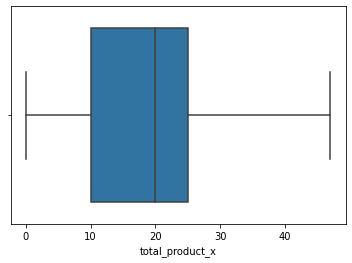

In [322]:
sns.boxplot(data=avg_client,x='total_product_x')

<AxesSubplot:xlabel='total_orders'>

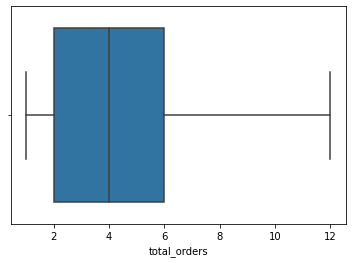

In [323]:
sns.boxplot(data=avg_client,x='total_orders')

El cliente de media  compra 20 productos y realiza 4 ordenes

*productos vendidos por tipo de fruta*

In [327]:
df_orders_fruits =df_trim_orders.groupby(['FRUIT_PRODUCT'])['NB PRODS'].sum()

In [328]:
df_orders_fruits

FRUIT_PRODUCT
Apple           5556
Apricot         8308
Banana         14374
Blueberry       3626
Cheery         20384
Coconut         9216
Devil Fruit     4992
Grape           5453
Jackfruit       1919
Kiwi           28549
Lemon          26705
Lime            5096
Mango           4285
Melon           2719
Nectarine      15626
Nuwe Fruit     16276
Orange         26715
Papaya          6925
Pear           17692
Pineapple       3140
Plum            3136
Pomegranate     4120
Strawberry      5216
Watermelon      3547
Name: NB PRODS, dtype: int64

Text(0.5, 1.0, 'Frutas menos vendias')

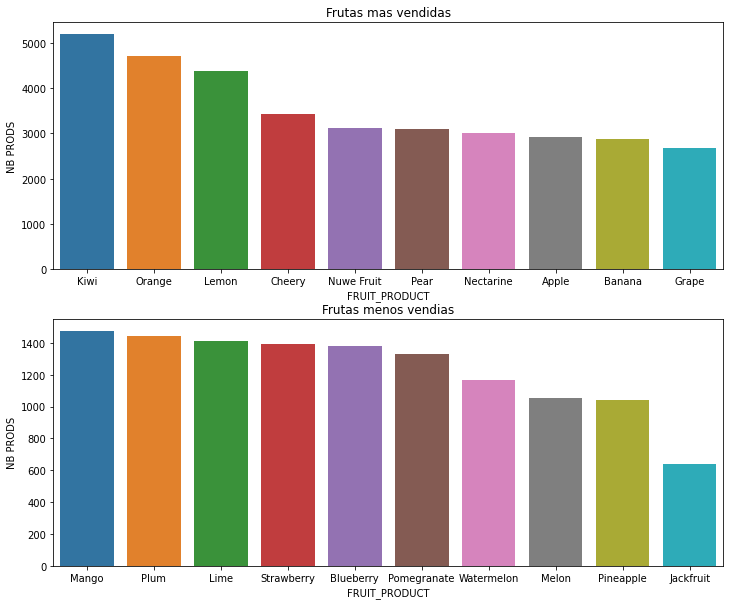

In [335]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
sns.barplot(data=top_fruits,ax=axes[0],x='FRUIT_PRODUCT',y='NB PRODS').set_title('Frutas mas vendidas')
sns.barplot(data=bottom_fruits,ax=axes[1],x='FRUIT_PRODUCT',y='NB PRODS').set_title('Frutas menos vendias')


# Modelo predictivo 

In [31]:
df_clients

,CLIENT ID,CLIENT_SEGMENT,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
0,24321771,6,67.25,201.75,0
1,24321859,2,58.33,350.00,0
2,24321880,3,46.67,112.00,0
4,24321962,4,10.00,120.00,0
5,24322000,5,9.17,110.00,0
...,...,...,...,...,...
35879,48345531,4,12.50,150.00,1
35880,48345686,3,37.50,112.50,1
35881,48365750,3,41.67,125.00,1
35882,48365861,3,62.58,125.17,1


In [45]:
X=df_clients.drop(['CLIENT ID','CLIENT_SEGMENT'],axis=1)
y=df_clients['CLIENT_SEGMENT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [46]:
clf = RFC()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [49]:
f1_score_svm= metrics.f1_score(y_test,y_pred,average='micro')
print(f1_score_svm)

0.7690200852099818


In [52]:
xgb_class =xgb.XGBClassifier(eval_metric='mlogloss',use_label_encoder =False)
xgb_class.fit(X_train,y_train)
y_pred=xgb_class.predict(X_test)

[23:37:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [54]:
f1_score_xgb = metrics.f1_score(y_test,y_pred,average='micro')
print(f1_score_xgb)

0.7789105295191723


In [75]:
scaler = StandardScaler()

In [76]:
Xs=scaler.fit_transform(X)

In [77]:
xgb_class =xgb.XGBClassifier(eval_metric='mlogloss',use_label_encoder =False)
xgb_class.fit(X_train,y_train)
y_pred=xgb_class.predict(X_test)

[23:47:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [78]:
f1_score_xgb = metrics.f1_score(y_test,y_pred,average='micro')
print(f1_score_xgb)

0.7789105295191723


In [87]:
df_test=pd.read_csv('mwc22-client_table+-+test_x.csv')
df_test_pred=df_test.drop('CLIENT ID',axis=1)
for atr in X.keys():
    if df_test_pred.dtypes[atr]==np.object:
        df_test_pred[atr].replace(',','.',inplace=True,regex=True)
        df_test_pred[atr]=df_test_pred[atr].astype(float)

In [88]:
y_pred=xgb_class.predict(df_test_pred)

In [89]:
y_pred['ClIENT ID']=df_test['CLIENT ID']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [95]:
result=df_test['CLIENT ID']

In [99]:
result['y_pred']=pd.DataFrame(y_pred)

In [101]:
result=pd.DataFrame(y_pred)

In [103]:
result['CLIENT ID']=df_test['CLIENT ID']

In [105]:
result=result[['CLIENT ID',0]]

In [106]:
result.rename(columns={0:'CLIENT SEGMENT'})

,CLIENT ID,CLIENT SEGMENT
0,48352078,4
1,18072186,1
2,48352246,3
3,18070621,4
4,48352262,4
5,48359553,4
6,18071647,4
7,48359574,3
8,48359627,4
9,18070505,1


In [107]:
result.to_csv()

',CLIENT ID,0\r\n0,48352078,4\r\n1,18072186,1\r\n2,48352246,3\r\n3,18070621,4\r\n4,48352262,4\r\n5,48359553,4\r\n6,18071647,4\r\n7,48359574,3\r\n8,48359627,4\r\n9,18070505,1\r\n10,18071016,1\r\n11,18071198,1\r\n12,18071233,2\r\n13,18071524,5\r\n14,18071668,1\r\n15,18072476,6\r\n16,48352272,3\r\n17,18072741,1\r\n18,18072797,1\r\n'